# Advanced: LC estimators

## Setup

Let's first make sure we have the latest version of PHOEBE 2.3 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.3,<2.4"

In [2]:
import phoebe
from phoebe import u # units
import numpy as np

logger = phoebe.logger()

## Generate data

Let's first initialize a bundle and change some of the parameter values. We'll then export the computed models as "observables" to use with the [EBAI](../api/phoebe.parameters.solver.estimator.ebai.md) and [lc_geometry](../api/phoebe.parameters.solver.estimator.lc_geometry.md) estimators.

We'll use blackbody atmospheres with manual limb-darkening just to avoid any out-of-bounds errors if the estimates aren't perfectly physical.  Normally we would check these values to make sure they're reasonable before adopting and would definitely want to revert to physical atmospheres and appropriate limb-darkening when optimizing.

In [3]:
b = phoebe.default_binary()
# set parameter values
b.set_value('q', value = 0.6)
b.set_value('incl', component='binary', value = 84.5)
b.set_value('ecc', 0.2)
b.set_value('per0', 63.7)
b.set_value('requiv', component='primary', value=1.)
b.set_value('requiv', component='secondary', value=0.6)
b.set_value('teff', component='secondary', value=5500.)

# add an lc dataset
b.add_dataset('lc', compute_phases=phoebe.linspace(0,1,101))
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_mode_bol', 'manual')
b.set_value_all('atm', 'blackbody')

#compute the model
b.run_compute(irrad_method='none')

# extract the arrays from the model that we'll use as observables in the next step
times = b.get_value('times', context='model', dataset='lc01')
# here we're adding noise to the fluxes as well to make the fake data more "realistic"
np.random.seed(0) # to ensure reproducibility with added noise
fluxes = b.get_value('fluxes', context='model', dataset='lc01') + np.random.normal(size=times.shape) * 0.02
sigmas_lc = np.ones_like(times) * 0.04

100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


## Initialize the bundle

To showcase the estimators, we'll start with a fresh default bundle and set the `pblum_mode` to 'dataset-scaled' to simplify the comparison between the light curves.  Fore more information, see the [pblum tutorial](./pblum.ipynb).

100%|██████████| 101/101 [00:01<00:00, 77.76it/s]


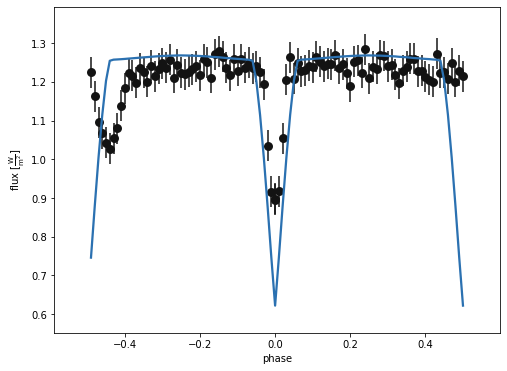

In [4]:
b = phoebe.default_binary()
b.add_dataset('lc', times=times, fluxes=fluxes, sigmas=sigmas_lc)
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_mode_bol', 'manual')
b.set_value_all('atm', 'blackbody')
b.set_value('pblum_mode', 'dataset-scaled')

b.run_compute(model='default')
_ = b.plot(x='phase', show=True)

## EBAI

Let's start with the [EBAI estimator](../api/phoebe.parameters.solver.estimator.ebai.md), which with the help of a trained neural network estimates of the time of superior conjunction, sum of equivalent radii, inclination,  temperature ratio, esinw and ecosw.  

**NOTE**: EBAI currently only works if the eclipse widths are less than 0.25 in phase.  If (either) eclipse is detected to be wider than 0.25, NANs will be returned and an error will be raised when attempting to adopt the solution. 

First we add the solver options via [add_solver](../api/phoebe.frontend.bundle.Bundle.add_solver.md):

In [5]:
b.add_solver('estimator.ebai', solver='ebai01')
print(b.filter(solver='ebai01'))

Tue, 30 Mar 2021 09:37 BUNDLE       WARNING adding teffratio constraint to binary orbit (needed for ebai solver)
Tue, 30 Mar 2021 09:37 BUNDLE       WARNING adding requivsumfrac constraint to binary orbit (needed for ebai solver)


ParameterSet: 5 parameters
           comments@ebai01@solver: 
        lc_datasets@ebai01@solver: ['*']
          phase_bin@ebai01@solver: True
        phase_nbins@ebai01@solver: 500
              orbit@ebai01@solver: binary


As we can see, by default it selects all available LC datasets and bins the light curves to 500 bins. We can change any of these in the 'ebai01' object or in the call to [run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md). If there are less points that bins, the phase binning is skipped. Just in case, let's turn off the phase binning for this example, since we already have only 100 data points.

In [6]:
b['phase_bin@ebai01'] = False
print(b.filter(solver='ebai01'))

ParameterSet: 4 parameters
           comments@ebai01@solver: 
        lc_datasets@ebai01@solver: ['*']
          phase_bin@ebai01@solver: False
              orbit@ebai01@solver: binary


In [7]:
b.run_solver('ebai01', solution='ebai_solution')

<ParameterSet: 14 parameters | qualifiers: adopt_distributions, ebai_phases, input_sigmas, fitted_twigs, adopt_values, comments, ebai_fluxes, input_phases, fitted_values, fitted_units, adopt_parameters, orbit, fitted_uniqueids, input_fluxes>

Some of the parameters that the EBAI estimator returns are constrained, so to properly set their values through [adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md), we need to flip the relevant constraints first. Note that simply running `b.adopt_solution()` without this step will result in an error.

In [8]:
try:
    b.adopt_solution('ebai_solution')
except Exception as e:
    print(e)

Tue, 30 Mar 2021 09:37 BUNDLE       WARNING solution='ebai_solution' is not included in run_checks_solution@setting, so will not raise interactive warnings
Tue, 30 Mar 2021 09:37 BUNDLE       WARNING teffratio@binary@orbit@component is currently constrained but cannot automatically temporarily flip as solve_for has several options (teff@secondary@star@component, teff@primary@star@component).  Flip the constraint manually first, set adopt_values=False, or remove teffratio@binary@orbit@component from adopt_parameters.  If not addressed, this warning will continue to be raised and will throw an error at adopt_solution.
Tue, 30 Mar 2021 09:37 BUNDLE       WARNING requivsumfrac@binary@orbit@component is currently constrained but cannot automatically temporarily flip as solve_for has several options (requiv@primary@star@component, requiv@secondary@star@component, sma@binary@orbit@component).  Flip the constraint manually first, set adopt_values=False, or remove requivsumfrac@binary@orbit@com

failed to pass checks
Run Checks Report: FAIL
ERROR: teffratio@binary@orbit@component is currently constrained but cannot automatically temporarily flip as solve_for has several options (teff@secondary@star@component, teff@primary@star@component).  Flip the constraint manually first, set adopt_values=False, or remove teffratio@binary@orbit@component from adopt_parameters. (3 affected parameters, affecting adopt_solution)
ERROR: requivsumfrac@binary@orbit@component is currently constrained but cannot automatically temporarily flip as solve_for has several options (requiv@primary@star@component, requiv@secondary@star@component, sma@binary@orbit@component).  Flip the constraint manually first, set adopt_values=False, or remove requivsumfrac@binary@orbit@component from adopt_parameters. (3 affected parameters, affecting adopt_solution)
ERROR: esinw@binary@orbit@component is currently constrained but cannot automatically temporarily flip as solve_for has several options (ecc@binary@orbit@co

In [9]:
b.flip_constraint('requivsumfrac', solve_for='requiv@secondary')

b.flip_constraint('teffratio', solve_for='teff@secondary')
b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')

Tue, 30 Mar 2021 09:37 BUNDLE       ERROR   Constraint 'ecc@binary@orbit@constraint' raised the following error while attempting to solve for 'ecc@binary@orbit@component'.  Consider flipping the constraint or changing the value of one of ['per0@binary@orbit@component', 'esinw@binary@orbit@component', 'ecosw@binary@orbit@component', 'ecc@binary@orbit@component'] until the constraint succeeds.  Original error: esinw=0.0 and per0=0.0 results in nan for ecc


<ConstraintParameter: {per0@binary@component} = arctan2({esinw@binary@component}, {ecosw@binary@component}) (solar units) => 0.0 deg>

Finally, we can adopt the EBAI solution and see how it has improved the model light curve:

In [10]:
print(b.adopt_solution('ebai_solution'))

Tue, 30 Mar 2021 09:37 BUNDLE       WARNING solution='ebai_solution' is not included in run_checks_solution@setting, so will not raise interactive warnings


ParameterSet: 22 parameters
      t0_supconj@binary@component: 0.0 d
       teffratio@binary@component: 0.9452120645340858
   requivsumfrac@binary@component: 0.27105169344875957
           esinw@binary@component: 0.09596544317931732
           ecosw@binary@component: 0.16501851747946783
            incl@binary@component: 85.10664388760809 deg
C        teff@secondary@component: 5671.272387204515 K
C      requiv@secondary@component: 0.4365739752784257 solRad
C            ecc@binary@component: 0.190893890409631
C           per0@binary@component: 30.179862857755072 deg
C          asini@binary@component: 5.2806825294905195 solRad
C         asini@primary@component: 2.6403412647452598 solRad
C          incl@primary@component: 85.10664388760809 deg
C    requiv_max@primary@component: 1.6771211942687534 solRad
C       asini@secondary@component: 2.6403412647452598 solRad
C        incl@secondary@component: 85.10664388760809 deg
C  requiv_max@secondary@component: 1.6771211942687534 solRad
C        

100%|██████████| 101/101 [00:10<00:00,  9.59it/s]


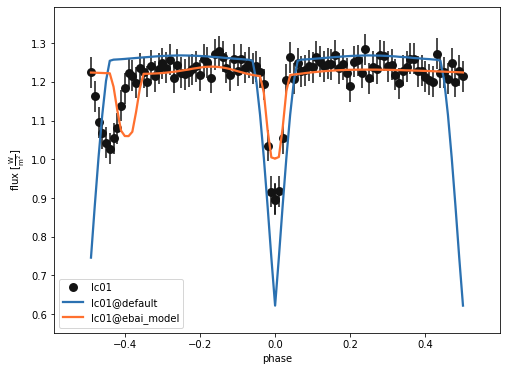

In [11]:
b.run_compute(model='ebai_model')
_ = b.plot(x='phase', ls='-', legend=True, show=True)

## lc_geometry

The EBAI estimator is known to have deficiencies in correctly estimating the eccentricity and argument of periastron, which can be seen in our solution too. To improve this, we can use the [lc_geometry estimator](../api/phoebe.parameters.solver.estimator.lc_geometry.md), which is specifically tailored to estimating eccentricty and argument of periastron by determining the eclipse separation and widths.

In [12]:
b.add_solver('estimator.lc_geometry', solver='lcgeom')

<ParameterSet: 8 parameters | qualifiers: phase_nbins, lc_datasets, comments, expose_model, orbit, t0_near_times, lc_combine, phase_bin>

In [13]:
print(b.filter(solver='lcgeom'))

ParameterSet: 7 parameters
           comments@lcgeom@solver: 
        lc_datasets@lcgeom@solver: ['*']
          phase_bin@lcgeom@solver: True
        phase_nbins@lcgeom@solver: 500
              orbit@lcgeom@solver: binary
      t0_near_times@lcgeom@solver: True
       expose_model@lcgeom@solver: True


The lc_geometry estimator takes similar inputs as EBAI, with two additions: `t0_near_times`, which will return the value of t0_supconj such that it falls within or near the provided times array (otherwise it will be a value in the range [0, period]) and `expose_model`, which if true returns the analytical, two-Gaussian model fit that's used to determine the eclipse parameters.

In [14]:
b.run_solver('lcgeom', solution='lcgeom_solution')

/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:10103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._value = np.array(value)


<ParameterSet: 22 parameters | qualifiers: adopt_distributions, input_sigmas, secondary_depth, adopt_parameters, fitted_uniqueids, primary_depth, secondary_phase, comments, input_phases, secondary_width, analytic_phases, eclipse_edges, input_fluxes, primary_width, primary_phase, analytic_best_model, orbit, analytic_fluxes, adopt_values, fitted_units, fitted_values, fitted_twigs>

The resulting solution returns our values of interest: eccentricity and argument of periastron, as well as the analytical fluxes of all two-Gaussian models (since `expose_model = True`) and the eclipse parameters determined from the best fit:

In [15]:
print(b.filter(solution='lcgeom_solution'))

ParameterSet: 22 parameters
R  orbit@lcgeom@lcgeom_solutio...: binary
R  input_phases@lcgeom@lcgeom_...: [-0.49 -0.48 -0.47 ...  0.48
  0.49  0.5 ]
R  input_fluxes@lcgeom@lcgeom_...: [0.99742541 0.94659581
 0.89184777 ... 0.9772116
 1.         0.98871388]
R  input_sigmas@lcgeom@lcgeom_...: [0.0325658 0.0325658
 0.0325658 ... 0.0325658
 0.0325658 0.0325658]
R  analytic_phases@lcgeom_solu...: [-0.5   -0.495 -0.49  ...  0.49
  0.495  0.5  ]
R  analytic_fluxes@lcgeom_solu...: {'C': array([0.98376088, 0.98376088, 0.98376088, 0.98376088, 0.98376088,
       0.98376088, 0.98376088, 0.98376088, 0.98376088, 0.98376088,
       0.98376088, 0.98376088, 0.98376088, 0.98376088, 0.98376088,
       0.98376088, 0.98376088, 0.98376088, 0.98376088, 0.98376088,
       0.98376088, 0.98376088, 0.98376088, 0.98376088, 0.98376088,
       0.98376088, 0.98376088, 0.98376088, 0.98376088, 0.98376088,
       0.98376088, 0.98376088, 0.98376088, 0.98376088, 0.98376088,
       0.98376088, 0.98376088, 0.98376088, 0.983

To update the values in the bundle, we need to reverse-flip the constraints for esinw and ecosw and adopt the solution.

In [16]:
b.flip_constraint('per0', solve_for='ecosw')
b.flip_constraint('ecc', solve_for='esinw')

<ConstraintParameter: {esinw@binary@component} = {ecc@binary@component} * (sin({per0@binary@component})) (solar units) => 0.09596544317931734>

In [17]:
print(b.adopt_solution('lcgeom_solution'))

Tue, 30 Mar 2021 09:38 BUNDLE       WARNING solution='lcgeom_solution' is not included in run_checks_solution@setting, so will not raise interactive warnings
Tue, 30 Mar 2021 09:38 PARAMETERS   WARNING wrapping value of mean_anom to 11.423035904805317 deg


ParameterSet: 11 parameters
      t0_supconj@binary@component: 0.9994160910857383 d
             ecc@binary@component: 0.2626371731381993
            per0@binary@component: 70.26416564970597 deg
C     t0_perpass@binary@component: 0.9682693920467413 d
C         t0_ref@binary@component: 1.0230911541308914 d
C     compute_phases@lc01@dataset: []
C    requiv_max@primary@component: 1.5411280459489891 solRad
C  requiv_max@secondary@component: 1.5411280459489891 solRad
C          ecosw@binary@component: 0.0886883748322164
C          esinw@binary@component: 0.24720974269564044
C      mean_anom@binary@component: 11.423035904805317 deg


100%|██████████| 101/101 [00:10<00:00,  9.67it/s]


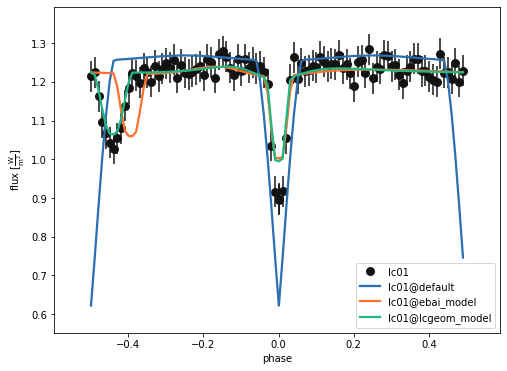

In [18]:
b.run_compute(model='lcgeom_model')
_ = b.plot(x='phases', ls='-', legend=True, show=True)

## phase masking

For more details on phase-masking see [Advanced: Phase Masking](mask_phases.ipynb).

lc_geometry also returns suggested `mask_phases` computed from the eclipse widths, which we can notice in the list of `fitted_twigs`. However, by default it is excluded from the `adopt_parameters` list:

In [19]:
print(b.get_value('fitted_twigs', solution='lcgeom_solution'))
print(b.get_value('adopt_parameters', solution='lcgeom_solution'))

['t0_supconj@binary@orbit@component' 'ecc@binary@orbit@component'
 'per0@binary@orbit@component' 'mask_phases@binary@lc01@lc@dataset']
['t0_supconj@binary@orbit@component', 'ecc@binary@orbit@component', 'per0@binary@orbit@component']


Therefore, we can set them in the bundle by either adding `mask_phases` the to the `adopt_parameters` list before calling `adopt_solution()`, or after, as:

In [20]:
b.set_value('mask_phases', b.get_value('fitted_values', solution='lcgeom_solution')[-1])

If we now plot the light curves, we'll see only the eclipses have been "masked out" of the data.

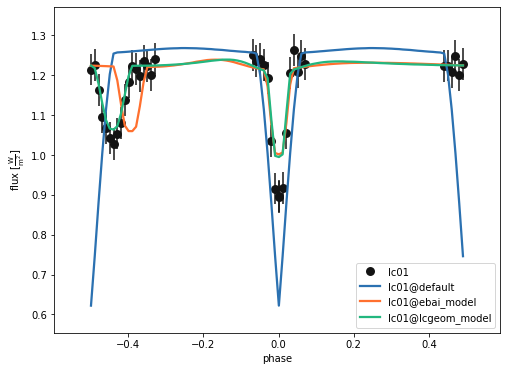

In [21]:
_ = b.plot(x='phases', ls='-', legend=True, show=True)